In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import dmba
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, precision_recall_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier 
from dmba import backward_elimination, forward_selection, stepwise_selection, classificationSummary

no display found. Using non-interactive Agg backend


In [3]:
DATA = Path('/Users/ujjwalsharma/Documents/207 Main Project/logit model final project/Loan_approval_prediction/dataset')
data=pd.read_csv(DATA/'SBAnational.csv')


/var/folders/l2/kkrqvk_j4dzdrf_zmgxd63280000gn/T/ipykernel_44658/3177441081.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv(DATA/'SBAnational.csv')


# Basic structure: dtypes and missing

In [4]:
summary = pd.concat([
    data.dtypes.rename('dtype'),
    data.nunique(dropna=True).rename('n_unique'),
    data.isna().sum().rename('n_missing'),
    (data.isna().mean() * 100).round(2).rename('%_missing')
], axis=1).reset_index().rename(columns={'index': 'column'})

summary


,column,dtype,n_unique,n_missing,%_missing
0,LoanNr_ChkDgt,int64,899164,0,0.00
1,Name,object,779583,14,0.00
2,City,object,32581,30,0.00
3,State,object,51,14,0.00
4,Zip,int64,33611,0,0.00
5,Bank,object,5802,1559,0.17
6,BankState,object,56,1566,0.17
7,NAICS,int64,1312,0,0.00
8,ApprovalDate,object,9859,0,0.00
9,ApprovalFY,object,70,0,0.00


# Drop the very sparse / leaky date (ChgOffDate) and clean money + dates

Since the ChgOffDate column was missing for over 80% of the observations and only populated for loans that had defaulted, it was both incredibly sparse and highly "leaky" in terms of the result, so I decided to remove it. In order to enable models to use loan size and approval amounts as continuous predictors, I then converted the important financial fields (DisbursementGross, BalanceGross, ChgOffPrinGr, GrAppv, SBA_Appv) from string formats with dollar signs and commas into numeric float variables.

In [5]:
# drop ChgOffDate: >80% missing and only defined for defaulted loans
if 'ChgOffDate' in data.columns:
    data = data.drop(columns=['ChgOffDate'])

print("After dropping ChgOffDate:", data.shape)

# convert money columns to numeric
money_cols = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']
for col in money_cols:
    data[col] = pd.to_numeric(
        data[col].astype(str).str.replace(r'[$,]', '', regex=True),
        errors='coerce'
    )

data[money_cols].dtypes


After dropping ChgOffDate: (899164, 26)


DisbursementGross    float64
BalanceGross         float64
ChgOffPrinGr         float64
GrAppv               float64
SBA_Appv             float64
dtype: object

In order for Python to treat the ApprovalDate and DisbursementDate columns as dates instead of plain text, I transformed them into appropriate datetime objects. This enables the robust derivation of time-based features (e.g., approval year or lag between approval and disbursement) and the verification of temporal consistency.

In [6]:
# parse dates to datetime
date_cols = ['ApprovalDate', 'DisbursementDate']
for col in date_cols:
    data[col] = pd.to_datetime(data[col], errors='coerce')

data[date_cols].dtypes

/var/folders/l2/kkrqvk_j4dzdrf_zmgxd63280000gn/T/ipykernel_44658/104710072.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col], errors='coerce')
/var/folders/l2/kkrqvk_j4dzdrf_zmgxd63280000gn/T/ipykernel_44658/104710072.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col], errors='coerce')


ApprovalDate        datetime64[ns]
DisbursementDate    datetime64[ns]
dtype: object

# Clean the target MIS_Status 

I removed rows with missing MIS_Status and then removed spaces to standardize the labels because the raw MIS_Status column contained values like "P I F" and "CHGOFF" with whitespace and some missing entries. In order to create a clean binary response variable appropriate for classification models and in line with the business question of differentiating between low-risk and high-risk loans, I then mapped "PIF" to 0 (paid in full, lower risk) and "CHGOFF" to 1 (default, higher risk).

In [7]:
# check raw values
print(data['MIS_Status'].value_counts(dropna=False))

# drop rows with missing MIS_Status (allowed early)
data = data[~data['MIS_Status'].isna()].copy()

# remove spaces and map to 0/1 (1 = default, 0 = paid in full)
data['MIS_Status'] = data['MIS_Status'].astype(str).str.replace(r'\s+', '', regex=True)
data['MIS_Status'] = data['MIS_Status'].map({'PIF': 0, 'CHGOFF': 1})

print("After cleaning MIS_Status:")
print(data['MIS_Status'].value_counts())
print("New shape:", data.shape)


MIS_Status
P I F     739609
CHGOFF    157558
NaN         1997
Name: count, dtype: int64
After cleaning MIS_Status:
MIS_Status
0    739609
1    157558
Name: count, dtype: int64
New shape: (897167, 26)


# Clean key categorical variables
# NewExist (existing vs new business)

Initially, the NewExist variable was represented by numerical codes (0, 1, 2) with a few anomalies and missing values that are difficult to understand on their own. I forced the column to be numeric, treated invalid codes as missing, and then mapped 1 to "Existing" and 2 to "New" so that the analysis and model could distinguish between loans for new ventures and those for existing businesses.

In [8]:
print("NewExist before cleaning:")
print(data['NewExist'].value_counts(dropna=False))

data['NewExist'] = pd.to_numeric(data['NewExist'], errors='coerce')
data.loc[~data['NewExist'].isin([1, 2]), 'NewExist'] = np.nan   # 0 and anything else -> NaN
data['NewExist'] = data['NewExist'].map({1: 'Existing', 2: 'New'})

print("\nNewExist after cleaning:")
print(data['NewExist'].value_counts(dropna=False))


NewExist before cleaning:
NewExist
1.0    643446
2.0    252559
0.0      1028
NaN       134
Name: count, dtype: int64

NewExist after cleaning:
NewExist
Existing    643446
New         252559
NaN           1162
Name: count, dtype: int64


# UrbanRural (urban / rural / undefined)

I mapped the integer codes (0, 1, 2) used in the UrbanRural field to the relevant categories "Urban", "Rural", and "Unknown". By maintaining a category for unclear or ambiguous situations, this recoding enhances interpretability and enables the model to detect any variations in credit risk between urban and rural borrowers.

In [9]:
print("UrbanRural before cleaning:")
print(data['UrbanRural'].value_counts(dropna=False))

urban_map = {1: 'Urban', 2: 'Rural', 0: 'Unknown'}
data['UrbanRural'] = data['UrbanRural'].map(urban_map)

print("\nUrbanRural after cleaning:")
print(data['UrbanRural'].value_counts(dropna=False))

UrbanRural before cleaning:
UrbanRural
1    469281
0    322826
2    105060
Name: count, dtype: int64

UrbanRural after cleaning:
UrbanRural
Urban      469281
Unknown    322826
Rural      105060
Name: count, dtype: int64



# LowDoc (Y / N)

I standardized the values by uppercasing, removing whitespace, and treating nonsensical entries as missing because LowDoc originally contained a mix of characters ('Y', 'N', digits, and other codes). In order to accurately capture whether the loan was processed under the Low Documentation program without confusing the model with noisy or ambiguous codes, I limited the cleaned variable to just three states: "Y", "N", or missing.

In [10]:
print("LowDoc before cleaning:")
print(data['LowDoc'].value_counts(dropna=False))

data['LowDoc'] = data['LowDoc'].astype(str).str.strip().str.upper()
data.loc[data['LowDoc'].isin(['NAN', '']), 'LowDoc'] = np.nan
data.loc[~data['LowDoc'].isin(['Y', 'N']) & data['LowDoc'].notna(), 'LowDoc'] = np.nan

print("\nLowDoc after cleaning (only Y/N or NaN):")
print(data['LowDoc'].value_counts(dropna=False))


LowDoc before cleaning:
LowDoc
N      780997
Y      110171
NaN      2578
0        1490
C         758
S         603
A         495
R          74
1           1
Name: count, dtype: int64

LowDoc after cleaning (only Y/N or NaN):
LowDoc
N      780997
Y      110171
NaN      5999
Name: count, dtype: int64


# RevLineCr (Y / N)

The RevLineCr variable contained a considerable amount of inconsistent codes and unsupported/extra characters - e.g., 'N', '0' , 'Y', so I normalized that to Upper Case Strings then replaced only the obvious Yes/No codes with "Y" and "N" and everything else was assigned a missing code. This creates a simple understandable indicator of whether a Revolving Line of Credit is present on the loan and is a much better fit for modelling purposes than the disorganized version.

In [11]:
print("RevLineCr before cleaning:")
print(data['RevLineCr'].value_counts(dropna=False).head(20))

rev = data['RevLineCr'].astype(str).str.strip().str.upper()
data['RevLineCr'] = np.nan
data.loc[rev.eq('Y'), 'RevLineCr'] = 'Y'
data.loc[rev.isin(['N', '0']), 'RevLineCr'] = 'N'   # treat 0 as "No line of credit"

print("\nRevLineCr after cleaning (Y/N/NaN):")
print(data['RevLineCr'].value_counts(dropna=False))


RevLineCr before cleaning:
RevLineCr
N      419252
0      257431
Y      200660
T       15239
NaN      4520
1          23
R          14
`          11
2           6
C           2
5           1
-           1
4           1
.           1
3           1
A           1
7           1
,           1
Q           1
Name: count, dtype: int64

RevLineCr after cleaning (Y/N/NaN):
RevLineCr
N      676683
Y      200660
NaN     19824
Name: count, dtype: int64


/var/folders/l2/kkrqvk_j4dzdrf_zmgxd63280000gn/T/ipykernel_44658/625629273.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Y' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[rev.eq('Y'), 'RevLineCr'] = 'Y'


# Clean ApprovalFY (fiscal year)

ApprovalFY sometimes has suffixes like 1976A. We keep just the 4-digit year.

In [12]:
print("ApprovalFY before cleaning:")
print(data['ApprovalFY'].value_counts().head(10))

data['ApprovalFY'] = data['ApprovalFY'].astype(str).str.extract(r'(\d{4})', expand=False)
data['ApprovalFY'] = pd.to_numeric(data['ApprovalFY'], errors='coerce')

print("\nApprovalFY after cleaning:")
print(data['ApprovalFY'].value_counts().sort_index().head(10))


ApprovalFY before cleaning:
ApprovalFY
2006    75756
2007    71649
2003    58000
2005    52390
1995    45688
2002    44307
2004    44270
2008    39458
1997    37718
2000    37352
Name: count, dtype: int64

ApprovalFY after cleaning:
ApprovalFY
1966     1
1968     1
1969     3
1970     8
1971    18
1972    25
1973    49
1974    42
1975    29
1976    83
Name: count, dtype: int64


# NAICS: 2-digit codes + sector buckets

To avoid excessive granularity of the full 6-digit NAICS codes, which produces multiple categories containing very few observations each, I created an aggregated NAICS_2digit variable by only retaining the first two digits of the NAICS code. The NAICS_2 digit class maintains the principal industry classification information while decreasing cardinality and reducing the potential risk of overfitting due to the existence of a small number of observations in small industry categories.

In [13]:
data['NAICS_2digit'] = data['NAICS'].astype(str).str.zfill(6).str[:2]

print("Top NAICS_2digit:")
print(data['NAICS_2digit'].value_counts().head(20))


Top NAICS_2digit:
NAICS_2digit
00    201667
44     84567
81     72395
54     67922
72     67511
23     66492
62     55264
42     48673
45     42408
33     38206
56     32529
48     20198
32     17905
71     14616
53     13588
31     11792
51     11362
52      9470
11      8995
61      6401
Name: count, dtype: int64


Mapping these codes to a broader cateogory to reduce the curse of dimentionality. Also, so it is eaiser to distinguish between the code. 

In [14]:
naics_sector_map = {
    '11': 'Agriculture, Forestry, Fishing & Hunting',
    '21': 'Mining, Quarrying, and Oil & Gas Extraction',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale Trade',
    '44': 'Retail Trade',
    '45': 'Retail Trade',
    '48': 'Transportation & Warehousing',
    '49': 'Transportation & Warehousing',
    '51': 'Information',
    '52': 'Finance & Insurance',
    '53': 'Real Estate & Rental & Leasing',
    '54': 'Professional, Scientific & Technical Services',
    '55': 'Management of Companies & Enterprises',
    '56': 'Administrative & Support & Waste Management & Remediation',
    '61': 'Educational Services',
    '62': 'Health Care & Social Assistance',
    '71': 'Arts, Entertainment & Recreation',
    '72': 'Accommodation & Food Services',
    '81': 'Other Services (except Public Administration)',
    '92': 'Public Administration'
}

data['NAICS_Sector'] = data['NAICS_2digit'].map(naics_sector_map)
data['NAICS_Sector'] = data['NAICS_Sector'].fillna('Other / Unknown')

print("\nNAICS_Sector counts:")
print(data['NAICS_Sector'].value_counts())



NAICS_Sector counts:
NAICS_Sector
Other / Unknown                                              201667
Retail Trade                                                 126975
Other Services (except Public Administration)                 72395
Professional, Scientific & Technical Services                 67922
Manufacturing                                                 67903
Accommodation & Food Services                                 67511
Construction                                                  66492
Health Care & Social Assistance                               55264
Wholesale Trade                                               48673
Administrative & Support & Waste Management & Remediation     32529
Transportation & Warehousing                                  22408
Arts, Entertainment & Recreation                              14616
Real Estate & Rental & Leasing                                13588
Information                                                   11362
Finance & Ins

# Location features: State buckets + simple ZIP feature

The activities of SBA by each individual state showed different States based on the different number(s); therefore, based upon these individual number(s), we could determine Low_Volume, Medium_Volume, Highest_Volume and also help identify the StateSizeGroup which would allow the analysis tool to differentiate between larger numbers for SBA numbers associated with that state compared to states with lower SBA totals; thus allowing less confusion and increased clarity with smaller state sample size(s).

In [15]:
state_counts = data['State'].value_counts().rename_axis('State').reset_index(name='RecordCount')

state_counts['StateSizeGroup'] = pd.cut(
    state_counts['RecordCount'],
    bins=[0, 5000, 20000, float('inf')],
    labels=['Low_Volume', 'Medium_Volume', 'High_Volume']
)

state_group_map = state_counts.set_index('State')['StateSizeGroup'].to_dict()
data['StateSizeGroup'] = data['State'].map(state_group_map)

print("StateSizeGroup counts:")
print(data['StateSizeGroup'].value_counts(dropna=False))


StateSizeGroup counts:
StateSizeGroup
High_Volume      598120
Medium_Volume    278667
Low_Volume        20367
NaN                  13
Name: count, dtype: int64


# ZIP3 frequency

I derived a ZIP3 variable based on the first three ZIP code digits and utilized that variable to classify into larger regional areas (by ZIP3). This allowed for the calculation of the number of loans made by SBA in each ZIP3 (ZIP3_freq) and for adding another numeric input variable to indicate the concentration of SBA loans in that region without the additional complication that could arise from having to create potentially thousands of unique ZIP codes.

In [16]:
data['ZIP3'] = data['Zip'].astype(str).str[:3]
zip3_counts = data['ZIP3'].value_counts()
data['ZIP3_freq'] = data['ZIP3'].map(zip3_counts).astype('int32')

data[['Zip', 'ZIP3', 'ZIP3_freq']].head()


,Zip,ZIP3,ZIP3_freq
0,47711,477,311
1,46526,465,1016
2,47401,474,421
3,74012,740,1528
4,32801,328,2340


# Franchise flag

The FranchiseCode column contains a large number of unique numeric identifiers, thus to simplify the analysis of this field, I created a Composite Field named FranchiseFlag which identifies if the loan is linked to a franchise or otherwise. The definition provided in the Data Dictionary gives an explanation of how to identify those loans that are not linked to franchises, since codes 0 and 1 designate non-Franchise entities. Therefore, I mapped these two codes to "No Franchise" and assigned the mapped value "Franchise" to all other FranchiseCodes to produce an easy to understand variable that indicates the presence of a franchise.

In [17]:
print("FranchiseCode sample:")
print(data['FranchiseCode'].value_counts().head(10))

data['FranchiseFlag'] = np.where(
    data['FranchiseCode'].isin([0, 1]),
    'No Franchise',
    'Franchise'
)

print("\nFranchiseFlag counts:")
print(data['FranchiseFlag'].value_counts())


FranchiseCode sample:
FranchiseCode
1        637395
0        208040
78760      3373
68020      1921
50564      1034
21780      1001
25650       715
79140       659
22470       615
17998       606
Name: count, dtype: int64

FranchiseFlag counts:
FranchiseFlag
No Franchise    845435
Franchise        51732
Name: count, dtype: int64


# numeric EDA

In [18]:
numeric_cols = ['Term', 'NoEmp', 'CreateJob', 'RetainedJob',
                'DisbursementGross', 'GrAppv', 'SBA_Appv', 'ZIP3_freq']

data[numeric_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
Term,897167.0,110.848592,78.900862,0.0,60.0,84.0,120.0,569.0
NoEmp,897167.0,11.412562,73.793775,0.0,2.0,4.0,10.0,9999.0
CreateJob,897167.0,8.444305,236.950249,0.0,0.0,0.0,1.0,8800.0
RetainedJob,897167.0,10.807308,237.382398,0.0,0.0,1.0,4.0,9500.0
DisbursementGross,897167.0,201598.034681,287806.620570,4000.0,42492.0,100000.0,239000.0,11446325.0
GrAppv,897167.0,193059.516894,283433.114425,1000.0,35000.0,90000.0,225000.0,5472000.0
SBA_Appv,897167.0,149780.698635,228559.979775,500.0,21250.0,62050.0,175000.0,5472000.0
ZIP3_freq,897167.0,2654.525243,2448.279279,1.0,926.0,1820.0,3495.0,12463.0


# Boxplots

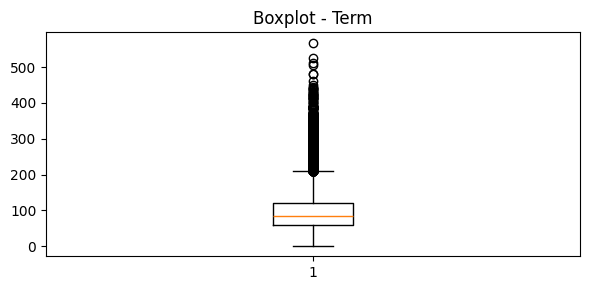

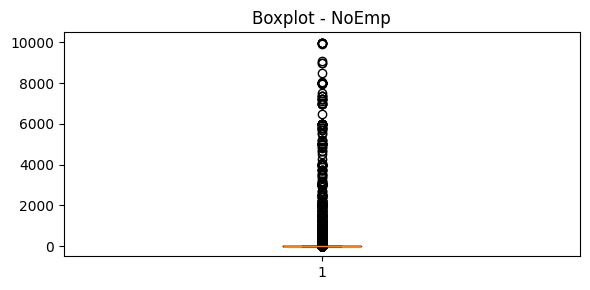

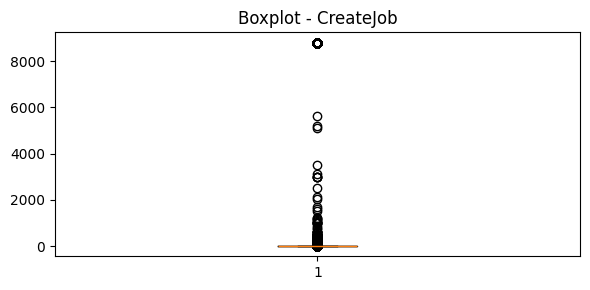

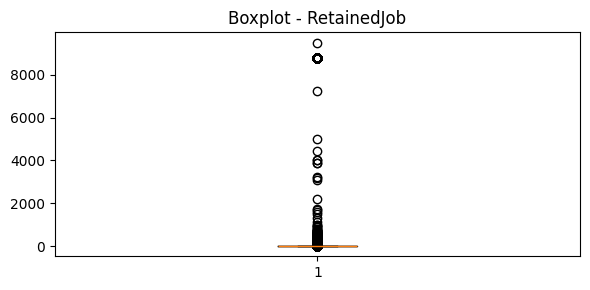

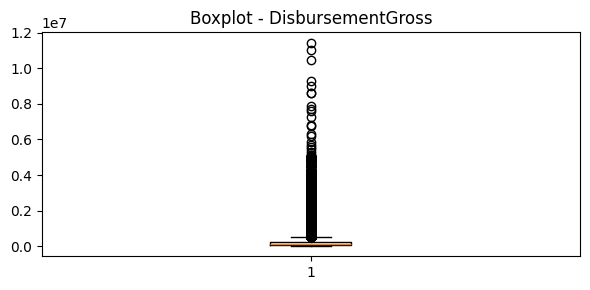

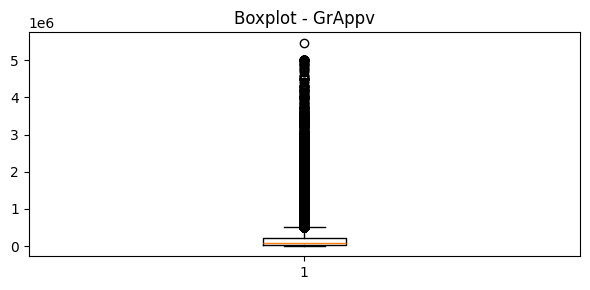

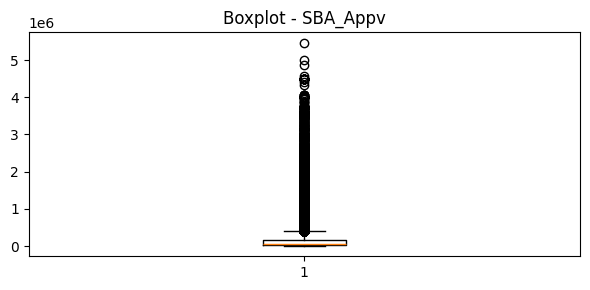

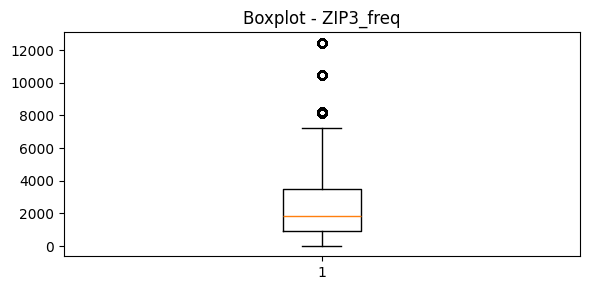

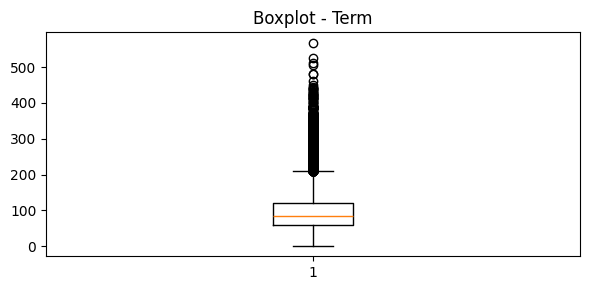

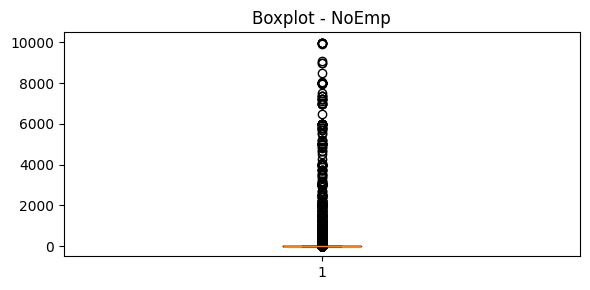

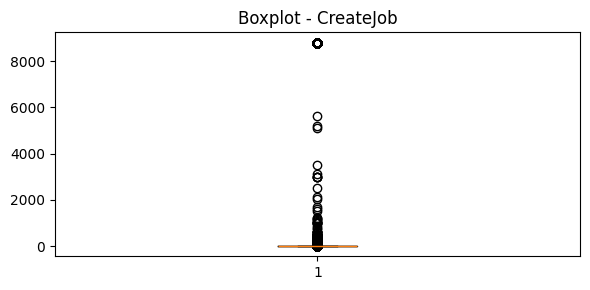

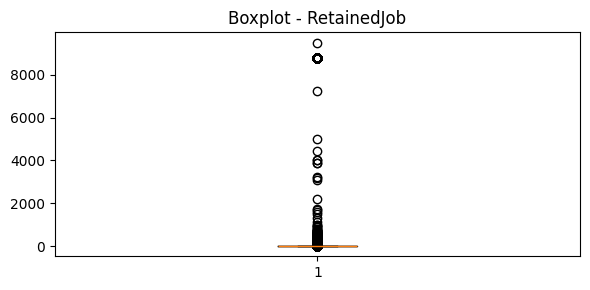

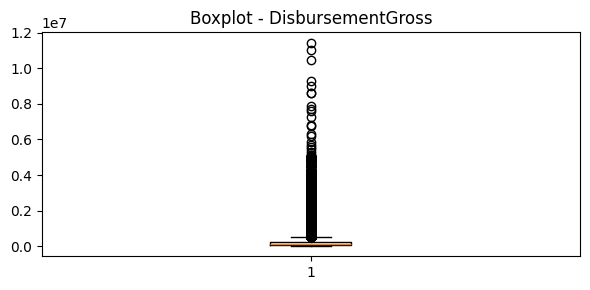

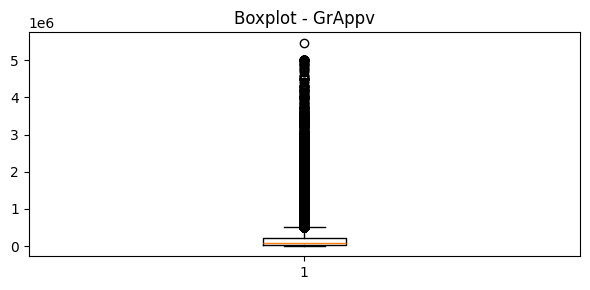

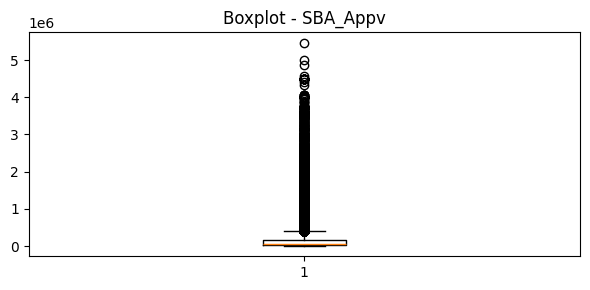

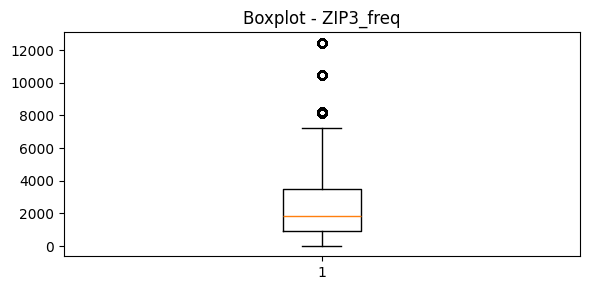

In [20]:
%matplotlib inline
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    plt.boxplot(data[col].dropna(), vert=True)
    plt.title(f'Boxplot - {col}')
    plt.tight_layout()
    plt.show()


# removing the column that cannot be used as predictors because it adds future information and causes multicollinearity issues and also repetitive columns

In [21]:
# columns we do NOT use as predictors
cols_to_drop = [
    'LoanNr_ChkDgt',  # ID
    'Name',
    'City',
    'Bank',
    'BankState',
    'ApprovalDate',
    'DisbursementDate',
    'Zip', # we use zip frequency instead 
    'ZIP3', # we uses zip frequency instead
    'BalanceGross',
    'ChgOffPrinGr',
    'NAICS',          # raw NAICS, we use NAICS_Sector instead
    'FranchiseCode',  # we use FranchiseFlag instead
    'NAICS_2digit'    # replaced by NAICS_Sector buckets
]

data_model = data.drop(columns=cols_to_drop)

print("Data_model shape before final dropna:", data_model.shape)
print("Missing rates before final dropna:")
print(data_model.isna().mean().sort_values(ascending=False).head(10))


Data_model shape before final dropna: (897167, 18)
Missing rates before final dropna:
RevLineCr         0.022096
LowDoc            0.006687
NewExist          0.001295
StateSizeGroup    0.000014
State             0.000014
CreateJob         0.000000
RetainedJob       0.000000
UrbanRural        0.000000
NoEmp             0.000000
ApprovalFY        0.000000
dtype: float64


# finally dropping all the missing value after fixing the dataset according to the data dictionary. This is why were are dropping the missing values and they are less than 5 percent so it wont affect the dataset. 

In [22]:
# final drop of rows with any missing values in the modeling features
data_model_final = data_model.dropna()
print("Data_model_final shape after final dropna:", data_model_final.shape)

# check that MIS_Status is still fine
print(data_model_final['MIS_Status'].value_counts(normalize=True))


Data_model_final shape after final dropna: (870502, 18)
MIS_Status
0    0.828537
1    0.171463
Name: proportion, dtype: float64


# preparing dummy variables 

In [23]:
cat_cols = [
    'State',
    'NewExist',
    'UrbanRural',
    'RevLineCr',
    'LowDoc',
    'NAICS_Sector',
    'StateSizeGroup',
    'FranchiseFlag'
]

data_dummies = pd.get_dummies(data_model_final, columns=cat_cols, drop_first=False)

print("Shape after get_dummies:", data_dummies.shape)
data_dummies.head()


Shape after get_dummies: (870502, 96)


,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,MIS_Status,GrAppv,SBA_Appv,ZIP3_freq,...,NAICS_Sector_Real Estate & Rental & Leasing,NAICS_Sector_Retail Trade,NAICS_Sector_Transportation & Warehousing,NAICS_Sector_Utilities,NAICS_Sector_Wholesale Trade,StateSizeGroup_High_Volume,StateSizeGroup_Low_Volume,StateSizeGroup_Medium_Volume,FranchiseFlag_Franchise,FranchiseFlag_No Franchise
0,1997,84,4,0,0,60000.0,0,60000.0,48000.0,311,...,False,True,False,False,False,False,False,True,False,True
1,1997,60,2,0,0,40000.0,0,40000.0,32000.0,1016,...,False,False,False,False,False,False,False,True,False,True
2,1997,180,7,0,0,287000.0,0,287000.0,215250.0,421,...,False,False,False,False,False,False,False,True,False,True
3,1997,60,2,0,0,35000.0,0,35000.0,28000.0,1528,...,False,False,False,False,False,False,False,True,False,True
4,1997,240,14,7,7,229000.0,0,229000.0,229000.0,2340,...,False,False,False,False,False,True,False,False,False,True


# assigning variables 

In [24]:
X = data_dummies.drop(columns=['MIS_Status'])
y = data_dummies['MIS_Status']

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (870502, 95)
y shape: (870502,)


### I will be using multiple train test split so i can reproduce results without any variable issues

# **Part 2**

# KNN

In [35]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.8, 
    random_state=1,
    stratify=y  # preserves class balance
)

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [ 10,11,12,13,14,15,16]
   
}

knn_grid = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

knn_grid.fit(X_train_scaled, y_train)

print("Best Parameters:", knn_grid.best_params_)
print("Best CV Score:", knn_grid.best_score_)


Best Parameters: {'n_neighbors': 13}
Best CV Score: 0.7987536312112281


In [38]:
# This model is already trained — no need to call fit() again
best_knn = knn_grid.best_estimator_

# Predictions
y_pred_knn = best_knn.predict(X_test_scaled)


# to check how model is performing confusion matrix, classification report, declile lift chart 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
print("CONFUSION MATRIX:")
print(cm_knn)

# Classification Report
cr_knn = classification_report(y_test, y_pred_knn)
print("\nCLASSIFICATION REPORT:")
print(cr_knn)


CONFUSION MATRIX:
[[559377  17618]
 [ 83344  36063]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92    576995
           1       0.67      0.30      0.42    119407

    accuracy                           0.86    696402
   macro avg       0.77      0.64      0.67    696402
weighted avg       0.84      0.86      0.83    696402



In [80]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
acc_knn = accuracy_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {acc_knn:.4f}")
print(f"KNN ROC-AUC: {roc_auc_knn:.4f}")

KNN Accuracy: 0.8550
KNN ROC-AUC: 0.6357


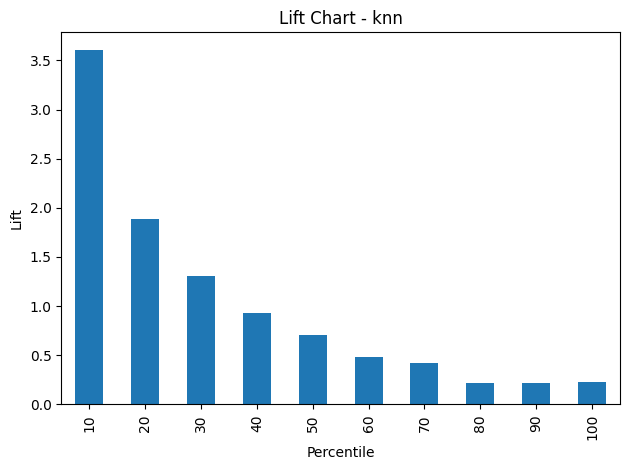

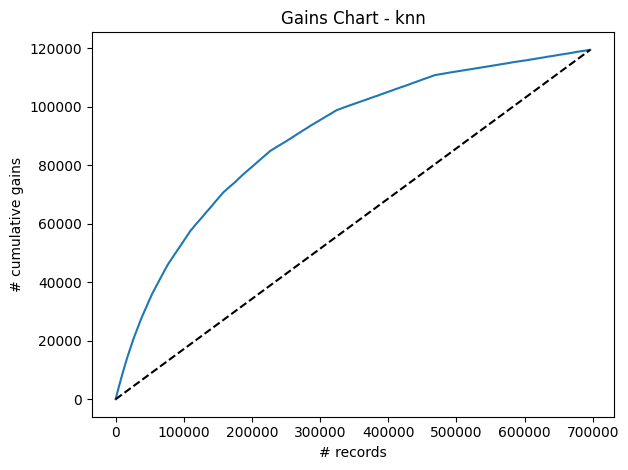

In [42]:
from dmba import liftChart, gainsChart

# predicted probabilities for positive class
y_pred_prob_knn = best_knn.predict_proba(X_test_scaled)[:, 1]

df_knn = pd.DataFrame({
    'prob': y_pred_prob_knn ,
    'actual': y_test.values
})

df_knn = df_knn.sort_values(by='prob', ascending=False).reset_index(drop=True)

ax = liftChart(df_knn.actual, labelBars=False)
plt.title('Lift Chart - knn')
plt.tight_layout()
plt.show()

ax = gainsChart(df_knn.actual)
plt.title('Gains Chart - knn')
plt.tight_layout()
plt.show()

# BEST CUTOFF FOR MAX NET PROFIT, COST-BASED CONFUSION MATRIX & METRICS, PROFIT-BASED CUMULATIVE GAIN CURVE

#### i was having trouble finding the best cut off for max net profit so i utilized outside source to do it

In [141]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

def evaluate_model_costs(model_name, y_true, y_prob, loan_amount,
                         profit_rate=0.05, loss_multiplier=5):
    """
    Evaluate model using SBA cost matrix:
      - +5% of loan amount for granting & PIF
      - -25% of loan amount for granting & default
      - 0 for denied loans
    Performs:
      • Threshold sweep (0.01→0.99)
      • Best cutoff selection
      • Net profit calculation
      • Cost-based confusion matrix & metrics
      • Cumulative profit curve analysis
    """


    print(f" MODEL: {model_name}")
    

    results = pd.DataFrame({
        'actual': y_true,
        'prob_default': y_prob,
        'amount': loan_amount
    })

    
    # FIND BEST CUTOFF FOR MAX NET PROFIT
    
    cutoffs = np.arange(0.01, 1.00, 0.01)
    net_profits = []

    for c in cutoffs:
        approve = results['prob_default'] < c

        profit = (
            np.where(approve & (results['actual'] == 0),
                     profit_rate * results['amount'], 0)
            +
            np.where(approve & (results['actual'] == 1),
                     -loss_multiplier * profit_rate * results['amount'], 0)
        )

        net_profits.append(profit.sum())

    profit_df = pd.DataFrame({'cutoff': cutoffs, 'net_profit': net_profits})

    best_idx = profit_df['net_profit'].idxmax()
    best_cutoff = profit_df.loc[best_idx, 'cutoff']
    best_profit = profit_df.loc[best_idx, 'net_profit']

    print(f"\nBest cutoff probability: {best_cutoff:.3f}")
    print(f"Max net profit: ${best_profit:,.2f}")

    
    # COST-BASED CONFUSION MATRIX & METRICS
    
    results['pred_default'] = (results['prob_default'] >= best_cutoff).astype(int)

    cm = confusion_matrix(results['actual'], results['pred_default'])
    print("\nCOST-BASED CONFUSION MATRIX:")
    print(cm)

    print("\nCOST-BASED CLASSIFICATION REPORT:")
    print(classification_report(results['actual'], results['pred_default']))

    accuracy = accuracy_score(results['actual'], results['pred_default'])
    auc = roc_auc_score(results['actual'], results['prob_default'])

    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {auc:.4f}")
    print(f"Sensitivity (Default Recall): {sensitivity:.4f}")
    print(f"Specificity (PIF Recall): {specificity:.4f}")

    
    # PROFIT-BASED CUMULATIVE GAIN CURVE
    
    results['profit_if_approved'] = np.where(
        results['actual'] == 0,
        profit_rate * results['amount'],
        -loss_multiplier * profit_rate * results['amount']
    )

    results_sorted = results.sort_values(
        by='prob_default', ascending=True
    ).reset_index(drop=True)

    results_sorted['cum_profit'] = results_sorted['profit_if_approved'].cumsum()
    results_sorted['fraction'] = (np.arange(len(results_sorted)) + 1) / len(results_sorted)

    max_cum_idx = results_sorted['cum_profit'].idxmax()
    best_fraction = results_sorted.loc[max_cum_idx, 'fraction']
    best_prob_cut2 = results_sorted.loc[max_cum_idx, 'prob_default']
    best_cum_profit = results_sorted.loc[max_cum_idx, 'cum_profit']

    print("\nCUMULATIVE PROFIT ANALYSIS:")
    print(f"Approve top {best_fraction*100:.2f}% safest loans for max gains")
    print(f"Corresponding cutoff (from gains curve): {best_prob_cut2:.4f}")
    print(f"Max cumulative profit: ${best_cum_profit:,.2f}")

    # Returning dictionary if needed for summary table
    return {
        'model': model_name,
        'best_cutoff': best_cutoff,
        'max_profit': best_profit,
        'gain_cutoff': best_prob_cut2,
        'gain_fraction': best_fraction,
        'gain_profit': best_cum_profit,
        'accuracy': accuracy,
        'auc': auc,
        'sensitivity': sensitivity,
        'specificity': specificity
    }


In [142]:
knn_eval = evaluate_model_costs(
    "kNN",
    y_test.values,
    y_pred_prob_knn,
    X_test['DisbursementGross'].values
)

 MODEL: kNN

Best cutoff probability: 0.160
Max net profit: $3,352,598,074.15

COST-BASED CONFUSION MATRIX:
[[434854 142141]
 [ 34516  84891]]

COST-BASED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83    576995
           1       0.37      0.71      0.49    119407

    accuracy                           0.75    696402
   macro avg       0.65      0.73      0.66    696402
weighted avg       0.83      0.75      0.77    696402

Accuracy: 0.7463
ROC-AUC: 0.8032
Sensitivity (Default Recall): 0.7109
Specificity (PIF Recall): 0.7537

CUMULATIVE PROFIT ANALYSIS:
Approve top 67.55% safest loans for max gains
Corresponding cutoff (from gains curve): 0.2308
Max cumulative profit: $3,353,438,027.40


# Decision Tree

In [43]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(
    X, y,
    test_size=0.8,
    random_state=1,
    stratify=y
)

In [47]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=1, class_weight={0:1, 1:5})

param_grid_dt = {
    'max_depth': [ 13,14,15,16],
    'min_samples_split': [ 180 ,200,220],
    'min_samples_leaf': [25, 50, 100],
    'criterion': ['gini', 'entropy']
}

dt_grid = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid_dt,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

dt_grid.fit(X_train_dt, y_train_dt)

print("Best Parameters:", dt_grid.best_params_)
print("Best CV Score:", dt_grid.best_score_)

Best Parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 50, 'min_samples_split': 220}
Best CV Score: 0.9678129930428605


In [48]:
best_dt = dt_grid.best_estimator_

y_pred_dt = best_dt.predict(X_test_dt)
y_pred_prob_dt = best_dt.predict_proba(X_test_dt)[:, 1]


In [49]:
from sklearn.metrics import confusion_matrix, classification_report

print("\nCONFUSION MATRIX - Decision Tree (Manual Weights):")
cm_dt = confusion_matrix(y_test_dt, y_pred_dt)
print(cm_dt)

print("\nCLASSIFICATION REPORT - Decision Tree (Manual Weights):")
cr_dt = classification_report(y_test_dt, y_pred_dt)
print(cr_dt)



CONFUSION MATRIX - Decision Tree (Manual Weights):
[[519667  57328]
 [  9231 110176]]

CLASSIFICATION REPORT - Decision Tree (Manual Weights):
              precision    recall  f1-score   support

           0       0.98      0.90      0.94    576995
           1       0.66      0.92      0.77    119407

    accuracy                           0.90    696402
   macro avg       0.82      0.91      0.85    696402
weighted avg       0.93      0.90      0.91    696402



In [81]:
roc_dt=roc_auc_score(y_test_dt, y_pred_prob_dt)
print(f"Decision Tree ROC-AUC: {roc_dt:.4f}")

Decision Tree ROC-AUC: 0.9669


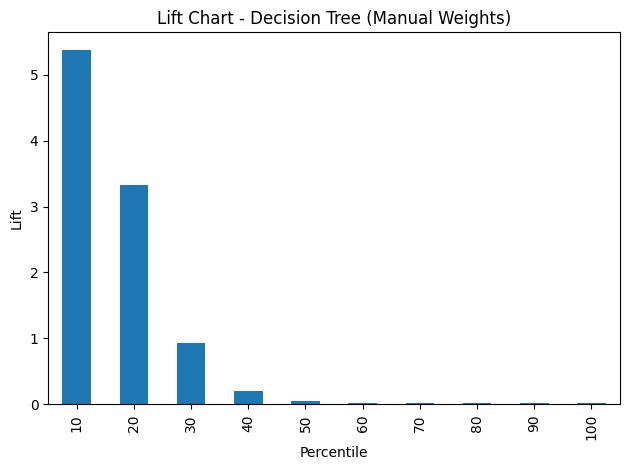

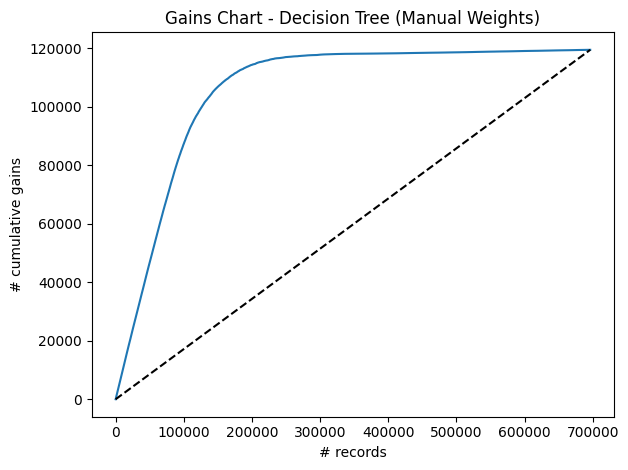

In [50]:

df_dt = pd.DataFrame({
    'prob': y_pred_prob_dt,
    'actual': y_test_dt.values
})

df_dt = df_dt.sort_values(by='prob', ascending=False).reset_index(drop=True)

ax = liftChart(df_dt.actual, labelBars=False)
plt.title("Lift Chart - Decision Tree (Manual Weights)")
plt.tight_layout()
plt.show()

ax = gainsChart(df_dt.actual)
plt.title("Gains Chart - Decision Tree (Manual Weights)")
plt.tight_layout()
plt.show()


In [143]:
dt_eval = evaluate_model_costs(
    "Decision Tree",
    y_test.values,
    y_pred_prob_dt,
    X_test['DisbursementGross'].values
)


 MODEL: Decision Tree

Best cutoff probability: 0.450
Max net profit: $5,179,754,900.35

COST-BASED CONFUSION MATRIX:
[[514042  62953]
 [  8153 111254]]

COST-BASED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.98      0.89      0.94    576995
           1       0.64      0.93      0.76    119407

    accuracy                           0.90    696402
   macro avg       0.81      0.91      0.85    696402
weighted avg       0.93      0.90      0.90    696402

Accuracy: 0.8979
ROC-AUC: 0.9669
Sensitivity (Default Recall): 0.9317
Specificity (PIF Recall): 0.8909

CUMULATIVE PROFIT ANALYSIS:
Approve top 74.19% safest loans for max gains
Corresponding cutoff (from gains curve): 0.4167
Max cumulative profit: $5,181,328,109.00


# Bagging 

In [51]:
X_train_bag, X_test_bag, y_train_bag, y_test_bag = train_test_split(
    X, y,
    test_size=0.8,
    random_state=1,
    stratify=y
)


base_tree_bag = DecisionTreeClassifier(
    random_state=1,
    class_weight={0:1, 1:5}   # same weighting as DT
)

In [ ]:
from sklearn.ensemble import BaggingClassifier


bag_model = BaggingClassifier(
    estimator=base_tree_bag,
    random_state=1,
    
)

param_grid_bag = {
    'n_estimators': [ 40, 80, 100,200,300],
    'max_samples': [0.6, 0.8, 1.0],
    'max_features': [0.5, 1.0],
    'bootstrap': [True, False]
}

bag_grid = GridSearchCV(
    estimator=bag_model,
    param_grid=param_grid_bag,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

bag_grid.fit(X_train_bag, y_train_bag)

print("Best Parameters:", bag_grid.best_params_)
print("Best CV AUC:", bag_grid.best_score_)


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'bootstrap': True, 'max_features': 1.0, 'max_samples': 0.6, 'n_estimators': 300}
Best CV AUC: 0.9736988758731494


In [59]:
best_bag = bag_grid.best_estimator_

y_pred_bag = best_bag.predict(X_test_bag)
y_pred_prob_bag = best_bag.predict_proba(X_test_bag)[:, 1]


In [60]:


print("\nCONFUSION MATRIX - Bagging:")
cm_bag = confusion_matrix(y_test_bag, y_pred_bag)
print(cm_bag)

print("\nCLASSIFICATION REPORT - Bagging:")
cr_bag = classification_report(y_test_bag, y_pred_bag)
print(cr_bag)



CONFUSION MATRIX - Bagging:
[[561054  15941]
 [ 21671  97736]]

CLASSIFICATION REPORT - Bagging:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    576995
           1       0.86      0.82      0.84    119407

    accuracy                           0.95    696402
   macro avg       0.91      0.90      0.90    696402
weighted avg       0.95      0.95      0.95    696402



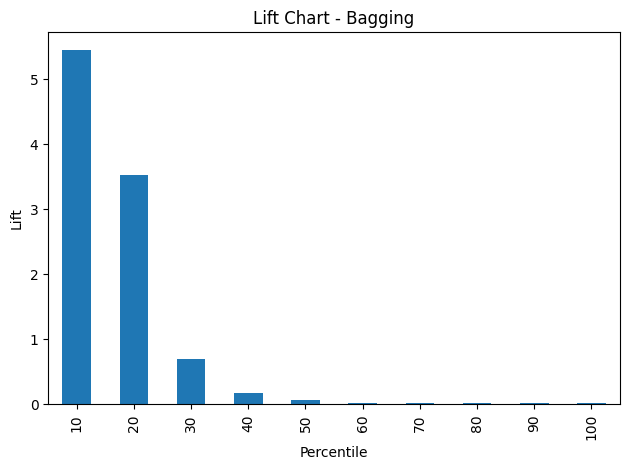

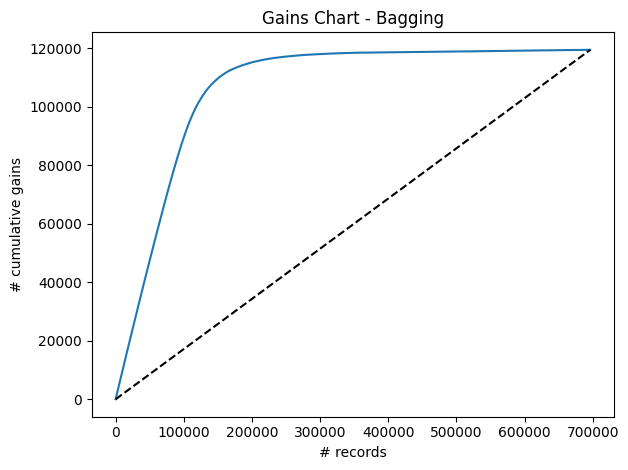

In [61]:

df_bag = pd.DataFrame({
    'prob': y_pred_prob_bag,
    'actual': y_test_bag.values
})

df_bag = df_bag.sort_values(by='prob', ascending=False).reset_index(drop=True)

# Lift Chart
ax = liftChart(df_bag.actual, labelBars=False)
plt.title('Lift Chart - Bagging')
plt.tight_layout()
plt.show()

# Gains Chart
ax = gainsChart(df_bag.actual)
plt.title('Gains Chart - Bagging')
plt.tight_layout()
plt.show()


In [144]:
bag_eval = evaluate_model_costs(
    "Bagging",
    y_test.values,
    y_pred_prob_bag,
    X_test['DisbursementGross'].values
)


 MODEL: Bagging

Best cutoff probability: 0.220
Max net profit: $5,286,742,711.15

COST-BASED CONFUSION MATRIX:
[[534347  42648]
 [  9263 110144]]

COST-BASED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95    576995
           1       0.72      0.92      0.81    119407

    accuracy                           0.93    696402
   macro avg       0.85      0.92      0.88    696402
weighted avg       0.94      0.93      0.93    696402

Accuracy: 0.9255
ROC-AUC: 0.9733
Sensitivity (Default Recall): 0.9224
Specificity (PIF Recall): 0.9261

CUMULATIVE PROFIT ANALYSIS:
Approve top 78.16% safest loans for max gains
Corresponding cutoff (from gains curve): 0.2200
Max cumulative profit: $5,287,615,866.95


# XGBoost 

In [62]:
X_train_xgb2, X_test_xgb2, y_train_xgb2, y_test_xgb2 = train_test_split(
    X, y,
    test_size=0.8,
    random_state=1,
    stratify=y
)

In [63]:
from xgboost import XGBClassifier

xgb_model2 = XGBClassifier(
    random_state=1
)

In [70]:
param_grid_xgb2 = {
    'max_depth': [3, 5, 6],
    'learning_rate': [ 0.1, 0.2],
    'n_estimators': [ 200,300],
    'subsample': [0.7,0.8, 1.0],
    'colsample_bytree': [0.7,0.8]
}

xgb_grid2 = GridSearchCV(
    estimator=xgb_model2,
    param_grid=param_grid_xgb2,
    cv=5,
    scoring='accuracy',   
    n_jobs=-1
)

xgb_grid2.fit(X_train_xgb2, y_train_xgb2)

print("Best Parameters:", xgb_grid2.best_params_)
print("Best CV Accuracy:", xgb_grid2.best_score_)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}
Best CV Accuracy: 0.9475875933371626


In [71]:
best_xgb2 = xgb_grid2.best_estimator_

y_pred_xgb2 = best_xgb2.predict(X_test_xgb2)
y_pred_prob_xgb2 = best_xgb2.predict_proba(X_test_xgb2)[:, 1]


In [72]:

print("\nCONFUSION MATRIX - XGBoost:")
cm_xgb2 = confusion_matrix(y_test_xgb2, y_pred_xgb2)
print(cm_xgb2)

print("\nCLASSIFICATION REPORT - XGBoost:")
cr_xgb2 = classification_report(y_test_xgb2, y_pred_xgb2)
print(cr_xgb2)



CONFUSION MATRIX - XGBoost:
[[561996  14999]
 [ 21740  97667]]

CLASSIFICATION REPORT - XGBoost:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    576995
           1       0.87      0.82      0.84    119407

    accuracy                           0.95    696402
   macro avg       0.91      0.90      0.91    696402
weighted avg       0.95      0.95      0.95    696402



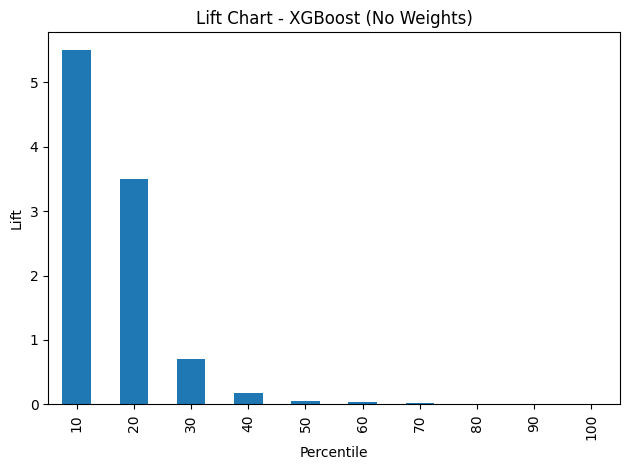

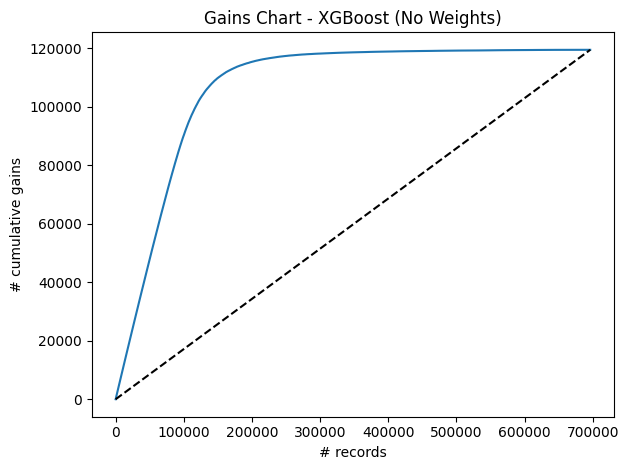

In [73]:
df_xgb2 = pd.DataFrame({
    'prob': y_pred_prob_xgb2,
    'actual': y_test_xgb2.values
})

df_xgb2 = df_xgb2.sort_values(by='prob', ascending=False).reset_index(drop=True)

# Lift Chart
ax = liftChart(df_xgb2.actual, labelBars=False)
plt.title('Lift Chart - XGBoost (No Weights)')
plt.tight_layout()
plt.show()

# Gains Chart
ax = gainsChart(df_xgb2.actual)
plt.title('Gains Chart - XGBoost (No Weights)')
plt.tight_layout()
plt.show()

In [145]:
xgb_eval = evaluate_model_costs(
    "XGBoost",
    y_test.values,
    y_pred_prob_xgb2,
    X_test['DisbursementGross'].values
)



 MODEL: XGBoost

Best cutoff probability: 0.140
Max net profit: $5,255,472,992.90

COST-BASED CONFUSION MATRIX:
[[527142  49853]
 [  7717 111690]]

COST-BASED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95    576995
           1       0.69      0.94      0.80    119407

    accuracy                           0.92    696402
   macro avg       0.84      0.92      0.87    696402
weighted avg       0.94      0.92      0.92    696402

Accuracy: 0.9173
ROC-AUC: 0.9758
Sensitivity (Default Recall): 0.9354
Specificity (PIF Recall): 0.9136

CUMULATIVE PROFIT ANALYSIS:
Approve top 76.71% safest loans for max gains
Corresponding cutoff (from gains curve): 0.1379
Max cumulative profit: $5,258,029,506.20


# Random Forest

In [74]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X, y,
    test_size=0.8,
    random_state=1,
    stratify=y
)

In [ ]:

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    random_state=1,
    n_jobs=-1,
    class_weight={0:1, 1:5}   
)

In [76]:
random_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'bootstrap': [True, False]
}

rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=random_param_grid,
    cv=5,
    scoring='accuracy',   \
    n_jobs=-1
)

rf_grid.fit(X_train_rf, y_train_rf)

print("Best Parameters:", rf_grid.best_params_)
print("Best CV Accuracy:", rf_grid.best_score_)

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Accuracy: 0.9301493394600804


In [77]:
best_rf = rf_grid.best_estimator_

y_pred_rf = best_rf.predict(X_test_rf)
y_pred_prob_rf = best_rf.predict_proba(X_test_rf)[:, 1]


In [78]:
print("\nCONFUSION MATRIX - Random Forest:")
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
print(cm_rf)

print("\nCLASSIFICATION REPORT - Random Forest:")
cr_rf = classification_report(y_test_rf, y_pred_rf)
print(cr_rf)


CONFUSION MATRIX - Random Forest:
[[564143  12852]
 [ 35081  84326]]

CLASSIFICATION REPORT - Random Forest:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96    576995
           1       0.87      0.71      0.78    119407

    accuracy                           0.93    696402
   macro avg       0.90      0.84      0.87    696402
weighted avg       0.93      0.93      0.93    696402



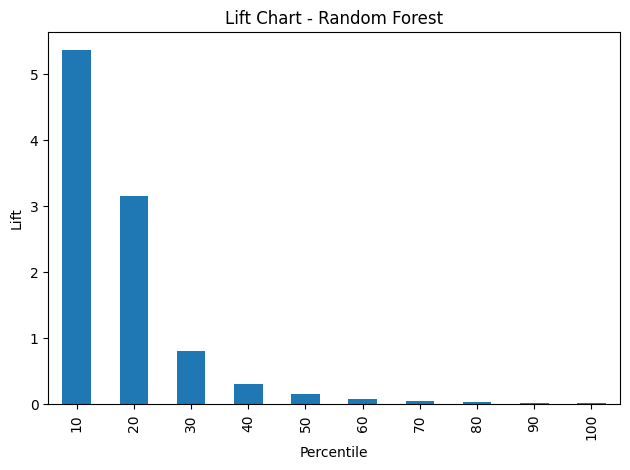

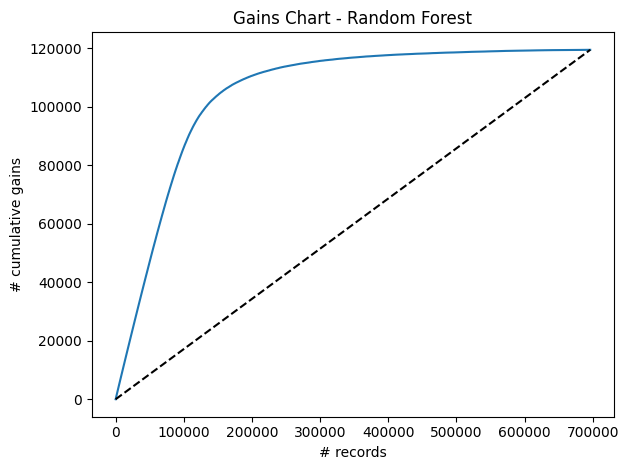

In [79]:
df_rf = pd.DataFrame({
    'prob': y_pred_prob_rf,
    'actual': y_test_rf.values
})

df_rf = df_rf.sort_values(by='prob', ascending=False).reset_index(drop=True)

# Lift Chart
ax = liftChart(df_rf.actual, labelBars=False)
plt.title('Lift Chart - Random Forest')
plt.tight_layout()
plt.show()

# Gains Chart
ax = gainsChart(df_rf.actual)
plt.title('Gains Chart - Random Forest')
plt.tight_layout()
plt.show()

In [146]:
rf_eval = evaluate_model_costs(
    "Random Forest",
    y_test.values,
    y_pred_prob_rf,
    X_test['DisbursementGross'].values
)


 MODEL: Random Forest

Best cutoff probability: 0.180
Max net profit: $4,842,130,693.35

COST-BASED CONFUSION MATRIX:
[[513947  63048]
 [ 12068 107339]]

COST-BASED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.98      0.89      0.93    576995
           1       0.63      0.90      0.74    119407

    accuracy                           0.89    696402
   macro avg       0.80      0.89      0.84    696402
weighted avg       0.92      0.89      0.90    696402

Accuracy: 0.8921
ROC-AUC: 0.9565
Sensitivity (Default Recall): 0.8989
Specificity (PIF Recall): 0.8907

CUMULATIVE PROFIT ANALYSIS:
Approve top 75.13% safest loans for max gains
Corresponding cutoff (from gains curve): 0.1750
Max cumulative profit: $4,843,156,262.70


# Logit Model (Ridge L2)

### selected the SAGA solver for logistic regression because it is built for large, high-dimensional, potentially sparse datasets, which matches our SBA loan data after dummy encoding, and it unifies support for L1, L2, and Elastic Net penalties.

### utilized grid search cv instead of logistic cv for logit model because to reduce the code work and keep everything constant like other models. GridSearchCV shows every parameter without having to call them one by one.

In [84]:
# Train/validation split for all logit models
X_train_log, X_valid_log, y_train_log, y_valid_log = train_test_split(
    X, y,
    test_size=0.3,
    random_state=1,
    stratify=y
)

# Keep the disbursed amount for later cost/profit calculations 
loan_amount_valid_log = X_valid_log['DisbursementGross'].values

# Normalize predictors for logistic models
scaler_log = StandardScaler()
X_train_log_scaled = scaler_log.fit_transform(X_train_log)
X_valid_log_scaled = scaler_log.transform(X_valid_log)

In [90]:

# Ridge-style Logistic Regression (L2 penalty) using SAGA
logit_ridge = LogisticRegression(
    penalty='l2',
    solver='saga',
    max_iter=5000,
    n_jobs=-1,class_weight={0:1, 1:5}
)

param_grid_ridge = {
    'C': [ 0.5, 1.0, 2.0],    # regularization strength
    'tol': [1e-4, 1e-3, 1e-2]       # solver convergence tolerance
}

logit_ridge_grid = GridSearchCV(
    estimator=logit_ridge,
    param_grid=param_grid_ridge,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

logit_ridge_grid.fit(X_train_log_scaled, y_train_log)
best_logit_ridge = logit_ridge_grid.best_estimator_

print("Best Ridge Logistic params:", logit_ridge_grid.best_params_)
print("Best Ridge CV accuracy:", logit_ridge_grid.best_score_)




Best Ridge Logistic params: {'C': 0.5, 'tol': 0.0001}
Best Ridge CV accuracy: 0.7052142351491211


In [91]:
y_pred_ridge = best_logit_ridge.predict(X_valid_log_scaled)
y_prob_ridge = best_logit_ridge.predict_proba(X_valid_log_scaled)[:, 1]

print("\nRidge Logistic - Validation Accuracy:", accuracy_score(y_valid_log, y_pred_ridge))
print("Ridge Logistic - Validation ROC-AUC:", roc_auc_score(y_valid_log, y_prob_ridge))

print("\nCONFUSION MATRIX - Ridge Logistic:")
print(confusion_matrix(y_valid_log, y_pred_ridge))

print("\nCLASSIFICATION REPORT - Ridge Logistic:")
print(classification_report(y_valid_log, y_pred_ridge))


Ridge Logistic - Validation Accuracy: 0.7033823343582831
Ridge Logistic - Validation ROC-AUC: 0.8317739485625961

CONFUSION MATRIX - Ridge Logistic:
[[146599  69774]
 [  7688  37090]]

CLASSIFICATION REPORT - Ridge Logistic:
              precision    recall  f1-score   support

           0       0.95      0.68      0.79    216373
           1       0.35      0.83      0.49     44778

    accuracy                           0.70    261151
   macro avg       0.65      0.75      0.64    261151
weighted avg       0.85      0.70      0.74    261151



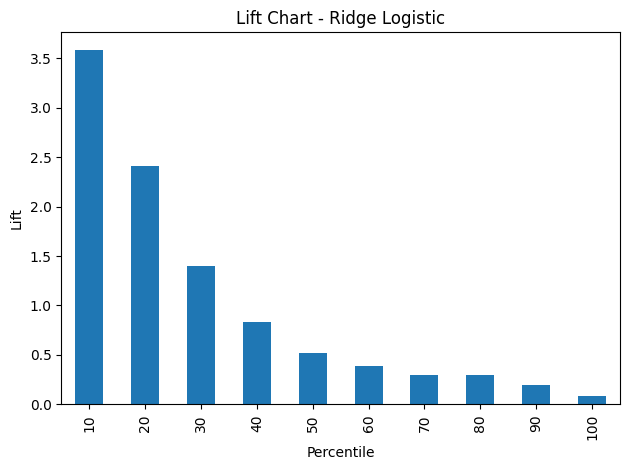

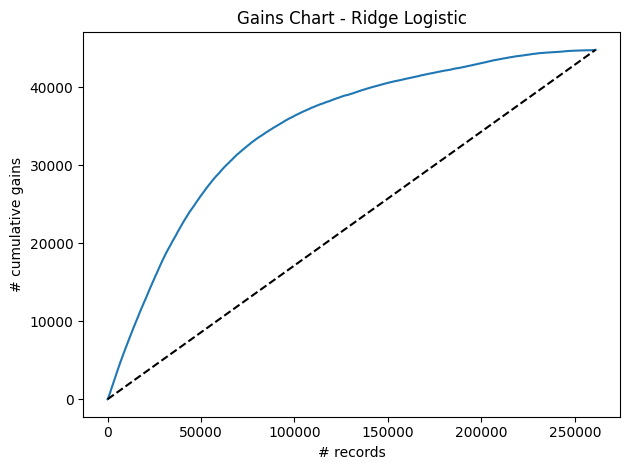

In [93]:
df_log = pd.DataFrame({
    'prob': y_prob_ridge,
    'actual': y_valid_log.values
})

df_log = df_log.sort_values(by='prob', ascending=False).reset_index(drop=True)

# Lift Chart
ax = liftChart(df_log.actual, labelBars=False)
plt.title('Lift Chart - Ridge Logistic')
plt.tight_layout()
plt.show()

# Gains Chart
ax = gainsChart(df_log.actual)
plt.title('Gains Chart - Ridge Logistic')
plt.tight_layout()
plt.show()

In [147]:
ridge_eval = evaluate_model_costs(
    "Ridge Logistic",
    y_valid_log.values,
    y_prob_ridge,
    loan_amount_valid_log
)


 MODEL: Ridge Logistic

Best cutoff probability: 0.580
Max net profit: $1,377,155,089.10

COST-BASED CONFUSION MATRIX:
[[170841  45532]
 [ 11581  33197]]

COST-BASED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86    216373
           1       0.42      0.74      0.54     44778

    accuracy                           0.78    261151
   macro avg       0.68      0.77      0.70    261151
weighted avg       0.85      0.78      0.80    261151

Accuracy: 0.7813
ROC-AUC: 0.8318
Sensitivity (Default Recall): 0.7414
Specificity (PIF Recall): 0.7896

CUMULATIVE PROFIT ANALYSIS:
Approve top 69.53% safest loans for max gains
Corresponding cutoff (from gains curve): 0.5775
Max cumulative profit: $1,378,262,227.00


# Lasso Logistic Regression (L1) with SAGA

In [94]:
# Lasso-style Logistic Regression (L1 penalty) using SAGA
logit_lasso = LogisticRegression(
    penalty='l1',
    solver='saga',
    max_iter=5000,
    n_jobs=-1, class_weight={0:1, 1:5}
)

param_grid_lasso = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'tol': [1e-4, 1e-3, 1e-2]
}

logit_lasso_grid = GridSearchCV(
    estimator=logit_lasso,
    param_grid=param_grid_lasso,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

logit_lasso_grid.fit(X_train_log_scaled, y_train_log)
best_logit_lasso = logit_lasso_grid.best_estimator_

print("Best Lasso Logistic params:", logit_lasso_grid.best_params_)
print("Best Lasso CV accuracy:", logit_lasso_grid.best_score_)



Best Lasso Logistic params: {'C': 10.0, 'tol': 0.01}
Best Lasso CV accuracy: 0.7052191580105844


In [95]:
y_pred_lasso = best_logit_lasso.predict(X_valid_log_scaled)
y_prob_lasso = best_logit_lasso.predict_proba(X_valid_log_scaled)[:, 1]

print("\nLasso Logistic - Validation Accuracy:", accuracy_score(y_valid_log, y_pred_lasso))
print("Lasso Logistic - Validation ROC-AUC:", roc_auc_score(y_valid_log, y_prob_lasso))

print("\nCONFUSION MATRIX - Lasso Logistic:")
print(confusion_matrix(y_valid_log, y_pred_lasso))

print("\nCLASSIFICATION REPORT - Lasso Logistic:")
print(classification_report(y_valid_log, y_pred_lasso))


Lasso Logistic - Validation Accuracy: 0.7034933812238896
Lasso Logistic - Validation ROC-AUC: 0.8318629575661036

CONFUSION MATRIX - Lasso Logistic:
[[146626  69747]
 [  7686  37092]]

CLASSIFICATION REPORT - Lasso Logistic:
              precision    recall  f1-score   support

           0       0.95      0.68      0.79    216373
           1       0.35      0.83      0.49     44778

    accuracy                           0.70    261151
   macro avg       0.65      0.75      0.64    261151
weighted avg       0.85      0.70      0.74    261151



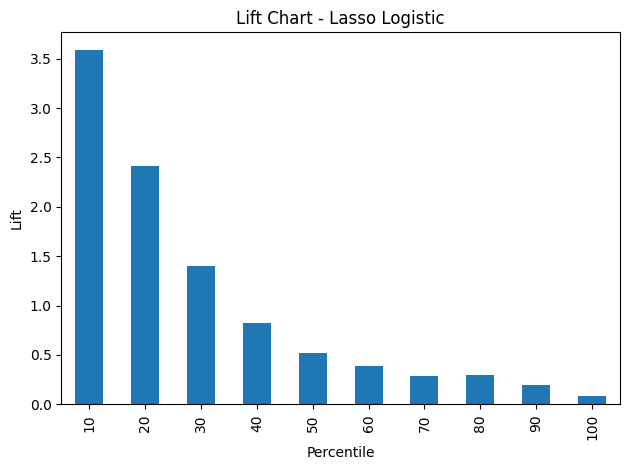

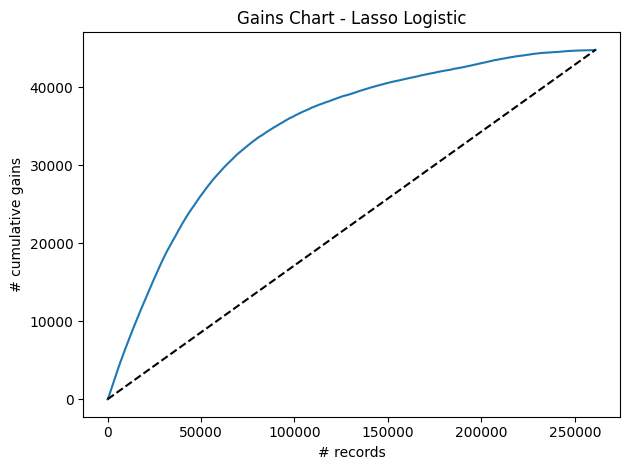

In [96]:
df_log = pd.DataFrame({
    'prob': y_prob_lasso,
    'actual': y_valid_log.values
})

df_log = df_log.sort_values(by='prob', ascending=False).reset_index(drop=True)

# Lift Chart
ax = liftChart(df_log.actual, labelBars=False)
plt.title('Lift Chart - Lasso Logistic')
plt.tight_layout()
plt.show()

# Gains Chart
ax = gainsChart(df_log.actual)
plt.title('Gains Chart - Lasso Logistic')
plt.tight_layout()
plt.show()

In [148]:
lasso_eval = evaluate_model_costs(
    "Lasso Logistic",
    y_valid_log.values,
    y_prob_lasso,
    loan_amount_valid_log
)


 MODEL: Lasso Logistic

Best cutoff probability: 0.580
Max net profit: $1,376,610,773.15

COST-BASED CONFUSION MATRIX:
[[170905  45468]
 [ 11584  33194]]

COST-BASED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86    216373
           1       0.42      0.74      0.54     44778

    accuracy                           0.78    261151
   macro avg       0.68      0.77      0.70    261151
weighted avg       0.85      0.78      0.80    261151

Accuracy: 0.7815
ROC-AUC: 0.8319
Sensitivity (Default Recall): 0.7413
Specificity (PIF Recall): 0.7899

CUMULATIVE PROFIT ANALYSIS:
Approve top 69.51% safest loans for max gains
Corresponding cutoff (from gains curve): 0.5772
Max cumulative profit: $1,377,236,322.90


# Elastic Net Logistic Regression with SAGA

In [103]:
# Elastic Net Logistic Regression (mix of L1 & L2) using SAGA
logit_en = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,   # will get overridden by GridSearchCV
    max_iter=5000,
    n_jobs=-1,
    class_weight={0:1, 1:5}
)

param_grid_en = {
    'C': [1.0, 10.0, 50.0],
    'tol': [1e-4, 1e-3, 1e-2],
    'l1_ratio': [0.2, 0.5, 0.8]   # this is your "E" (Elastic Net mixing parameter)
}

logit_en_grid = GridSearchCV(
    estimator=logit_en,
    param_grid=param_grid_en,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

logit_en_grid.fit(X_train_log_scaled, y_train_log)
best_logit_en = logit_en_grid.best_estimator_

print("Best Elastic Net Logistic params:", logit_en_grid.best_params_)
print("Best Elastic Net CV accuracy:", logit_en_grid.best_score_)

python(70391) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70392) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70393) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70394) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70395) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70396) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70397) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(70398) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best Elastic Net Logistic params: {'C': 10.0, 'l1_ratio': 0.2, 'tol': 0.01}
Best Elastic Net CV accuracy: 0.7052306456613598


In [104]:
y_pred_en = best_logit_en.predict(X_valid_log_scaled)
y_prob_en = best_logit_en.predict_proba(X_valid_log_scaled)[:, 1]

print("\nElastic Net Logistic - Validation Accuracy:", accuracy_score(y_valid_log, y_pred_en))
print("Elastic Net Logistic - Validation ROC-AUC:", roc_auc_score(y_valid_log, y_prob_en))

print("\nCONFUSION MATRIX - Elastic Net Logistic:")
print(confusion_matrix(y_valid_log, y_pred_en))

print("\nCLASSIFICATION REPORT - Elastic Net Logistic:")
print(classification_report(y_valid_log, y_pred_en))


Elastic Net Logistic - Validation Accuracy: 0.7034895520216273
Elastic Net Logistic - Validation ROC-AUC: 0.8318692262796923

CONFUSION MATRIX - Elastic Net Logistic:
[[146627  69746]
 [  7688  37090]]

CLASSIFICATION REPORT - Elastic Net Logistic:
              precision    recall  f1-score   support

           0       0.95      0.68      0.79    216373
           1       0.35      0.83      0.49     44778

    accuracy                           0.70    261151
   macro avg       0.65      0.75      0.64    261151
weighted avg       0.85      0.70      0.74    261151



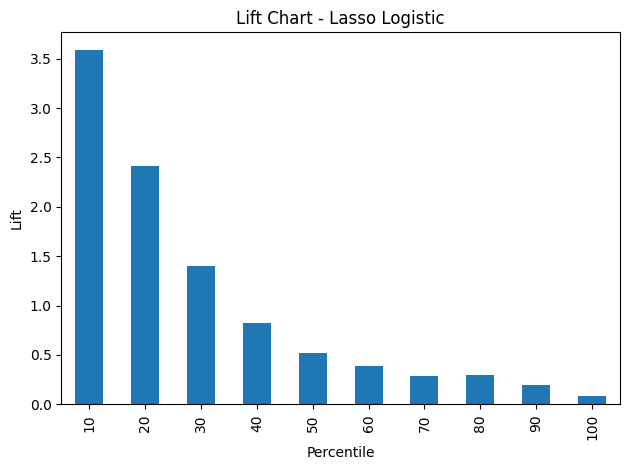

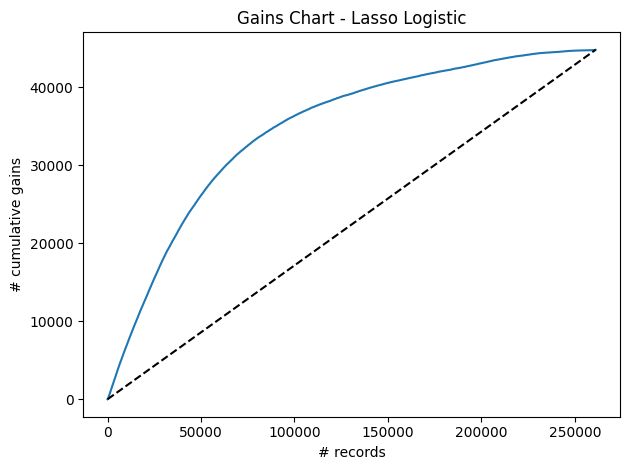

In [105]:
df_log = pd.DataFrame({
    'prob': y_prob_en,
    'actual': y_valid_log.values
})

df_log = df_log.sort_values(by='prob', ascending=False).reset_index(drop=True)

# Lift Chart
ax = liftChart(df_log.actual, labelBars=False)
plt.title('Lift Chart - Lasso Logistic')
plt.tight_layout()
plt.show()

# Gains Chart
ax = gainsChart(df_log.actual)
plt.title('Gains Chart - Lasso Logistic')
plt.tight_layout()
plt.show()

In [149]:
en_eval = evaluate_model_costs(
    "Elastic Net Logistic",
    y_valid_log.values,
    y_prob_en,
    loan_amount_valid_log
)


 MODEL: Elastic Net Logistic

Best cutoff probability: 0.580
Max net profit: $1,376,947,161.75

COST-BASED CONFUSION MATRIX:
[[170926  45447]
 [ 11586  33192]]

COST-BASED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86    216373
           1       0.42      0.74      0.54     44778

    accuracy                           0.78    261151
   macro avg       0.68      0.77      0.70    261151
weighted avg       0.85      0.78      0.80    261151

Accuracy: 0.7816
ROC-AUC: 0.8319
Sensitivity (Default Recall): 0.7413
Specificity (PIF Recall): 0.7900

CUMULATIVE PROFIT ANALYSIS:
Approve top 69.49% safest loans for max gains
Corresponding cutoff (from gains curve): 0.5771
Max cumulative profit: $1,377,431,198.75


# Neural Network 

In [106]:
from sklearn.neural_network import MLPClassifier

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X, y,
    test_size=0.9,
    random_state=1,
    stratify=y
)

scaler_nn = StandardScaler()
X_train_nn_scaled = scaler_nn.fit_transform(X_train_nn)
X_test_nn_scaled = scaler_nn.transform(X_test_nn)

In [ ]:
nn_model = MLPClassifier(
    activation='relu',
    solver='lbfgs',          # second-order optimizer (quasi-Newton)
    random_state=1,
    max_iter=100000
)

# Grid search over ONE hidden layer with different sizes
param_grid_nn = {
    'hidden_layer_sizes': [
        (8,),    # 1 hidden layer with 8 neurons
        (10,),    # 1 hidden layer with 10 neurons
        (12,)    # 1 hidden layer with 12 neurons    
    ]
}

nn_grid = GridSearchCV(
    estimator=nn_model,
    param_grid=param_grid_nn,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
) 

nn_grid.fit(X_train_nn_scaled, y_train_nn)

print("Best NN parameters:", nn_grid.best_params_)
print("Best NN CV accuracy:", nn_grid.best_score_)


python(72597) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72598) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72599) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72600) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(72601) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best NN parameters: {'hidden_layer_sizes': (10,)}
Best NN CV accuracy: 0.8956461807244774


In [111]:
best_nn = nn_grid.best_estimator_

y_pred_nn = best_nn.predict(X_test_nn_scaled)
y_pred_prob_nn = best_nn.predict_proba(X_test_nn_scaled)[:, 1]   # P(default=1)


# Metrics: confusion matrix, classification report, accuracy, AUC

print("\nNEURAL NETWORK (lbfgs) – Confusion Matrix:")
cm_nn = confusion_matrix(y_test_nn, y_pred_nn)
print(cm_nn)

print("\nNEURAL NETWORK (lbfgs) – Classification Report:")
cr_nn = classification_report(y_test_nn, y_pred_nn)
print(cr_nn)

print("NEURAL NETWORK (lbfgs) – Accuracy:", accuracy_score(y_test_nn, y_pred_nn))
print("NEURAL NETWORK (lbfgs) – ROC-AUC:", roc_auc_score(y_test_nn, y_pred_prob_nn))



NEURAL NETWORK (lbfgs) – Confusion Matrix:
[[622441  26678]
 [ 53722  80611]]

NEURAL NETWORK (lbfgs) – Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94    649119
           1       0.75      0.60      0.67    134333

    accuracy                           0.90    783452
   macro avg       0.84      0.78      0.80    783452
weighted avg       0.89      0.90      0.89    783452

NEURAL NETWORK (lbfgs) – Accuracy: 0.8973772483827982
NEURAL NETWORK (lbfgs) – ROC-AUC: 0.9090805136848795


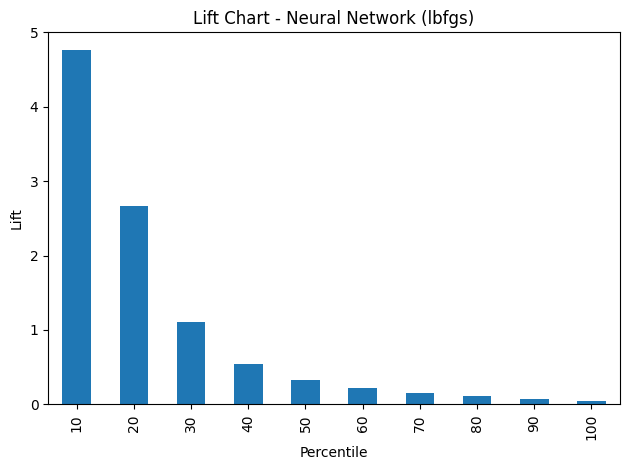

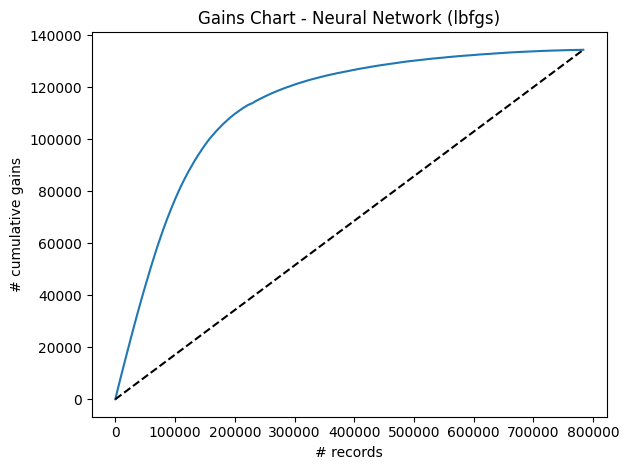

In [112]:
df_nn = pd.DataFrame({
    'prob': y_pred_prob_nn,
    'actual': y_test_nn.values
})

df_nn = df_nn.sort_values(by='prob', ascending=False).reset_index(drop=True)

ax = liftChart(df_nn['actual'], labelBars=False)
plt.title('Lift Chart - Neural Network (lbfgs)')
plt.tight_layout()
plt.show()

ax = gainsChart(df_nn['actual'])
plt.title('Gains Chart - Neural Network (lbfgs)')
plt.tight_layout()
plt.show()

In [150]:
nn_eval = evaluate_model_costs(
    "Neural Network (lbfgs)",
    y_test_nn.values,
    y_pred_prob_nn,
    X_test_nn['DisbursementGross'].values
)


 MODEL: Neural Network (lbfgs)

Best cutoff probability: 0.190
Max net profit: $4,820,547,231.90

COST-BASED CONFUSION MATRIX:
[[557535  91584]
 [ 24374 109959]]

COST-BASED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91    649119
           1       0.55      0.82      0.65    134333

    accuracy                           0.85    783452
   macro avg       0.75      0.84      0.78    783452
weighted avg       0.89      0.85      0.86    783452

Accuracy: 0.8520
ROC-AUC: 0.9091
Sensitivity (Default Recall): 0.8186
Specificity (PIF Recall): 0.8589

CUMULATIVE PROFIT ANALYSIS:
Approve top 74.50% safest loans for max gains
Corresponding cutoff (from gains curve): 0.1931
Max cumulative profit: $4,823,861,641.55


In [125]:
profit_summary = pd.DataFrame([
    knn_eval,
    dt_eval,
    bag_eval,
    rf_eval,
    xgb_eval,
    ridge_eval,
    lasso_eval,
    en_eval,
    nn_eval
])

print("\nNET PROFIT SUMMARY")
display(profit_summary)

best_model_idx = profit_summary['max_profit'].idxmax()
best_model = profit_summary.loc[best_model_idx]

print("\nBEST MODEL BY NET PROFIT")
print("Model:", best_model['model'])
print("Max Net Profit: $", best_model['max_profit'])
print("Optimal Threshold:", best_model['best_cutoff'])
print("Best Profit Cutoff (from gains curve):", best_model['gain_cutoff'])
print("Fraction of loans to approve:", best_model['gain_fraction'])



NET PROFIT SUMMARY


,model,best_cutoff,max_profit,gain_cutoff,gain_fraction,gain_profit,accuracy,auc,sensitivity,specificity
0,kNN,0.16,3.352598e+09,0.230769,0.675508,3.353438e+09,0.746329,0.803176,0.710938,0.753653
1,Decision Tree,0.45,5.179755e+09,0.416667,0.741902,5.181328e+09,0.897895,0.966908,0.931721,0.890895
2,Bagging,0.22,5.286743e+09,0.220000,0.781574,5.287616e+09,0.925458,0.973250,0.922425,0.926086
3,Random Forest,0.18,4.842131e+09,0.175000,0.751277,4.843156e+09,0.892137,0.956453,0.898934,0.890730
4,XGBoost,0.14,5.255473e+09,0.137865,0.767113,5.258030e+09,0.917332,0.975759,0.935372,0.913599
5,Ridge Logistic,0.58,1.377155e+09,0.577526,0.695299,1.378262e+09,0.781303,0.831774,0.741369,0.789567
6,Lasso Logistic,0.58,1.376611e+09,0.577224,0.695088,1.377236e+09,0.781536,0.831863,0.741302,0.789863
7,Elastic Net Logistic,0.58,1.376947e+09,0.577076,0.694927,1.377431e+09,0.781609,0.831869,0.741257,0.789960
8,Neural Network (lbfgs),0.19,4.820547e+09,0.193122,0.745037,4.823862e+09,0.851991,0.909081,0.818555,0.858910



BEST MODEL BY NET PROFIT
Model: Bagging
Max Net Profit: $ 5286742711.149999
Optimal Threshold: 0.22
Best Profit Cutoff (from gains curve): 0.22
Fraction of loans to approve: 0.7815744354553835


### Bagging produced the highest net profit 

# Part 3

In [136]:
df_bag = pd.DataFrame({
    'prob_default': y_pred_prob_bag,
    'actual': y_test.values,
    'loan_amount': X_test['DisbursementGross'].values
})

profit_rate = 0.05
loss_multiplier = 5

df_bag['profit'] = np.where(
    df_bag['actual'] == 0,
    profit_rate * df_bag['loan_amount'],
    -loss_multiplier * profit_rate * df_bag['loan_amount']
)

# For profit-based ranking, sort by SAFEST (lowest default prob first)
df_bag = df_bag.sort_values(by='prob_default', ascending=True).reset_index(drop=True)
print(df_bag.head())


   prob_default  actual  loan_amount    profit
0           0.0       0      51507.0   2575.35
1           0.0       1      44060.0 -11015.00
2           0.0       0      50000.0   2500.00
3           0.0       0     275800.0  13790.00
4           0.0       0     150000.0   7500.00


In [138]:
# cumulative profit
df_bag['cum_profit'] = df_bag['profit'].cumsum()

# scale to total possible profit if all loans approved
total_profit = df_bag['profit'].sum()
df_bag['gain'] = df_bag['cum_profit'] / total_profit

# lift = gain / fraction_of_loans
df_bag['fraction'] = (df_bag.index + 1) / len(df_bag)
df_bag['lift'] = df_bag['gain'] / df_bag['fraction']


#### so i couldnt find how to create gains and lift for net profit using class code so had to use outside source

<Figure size 1000x500 with 0 Axes>

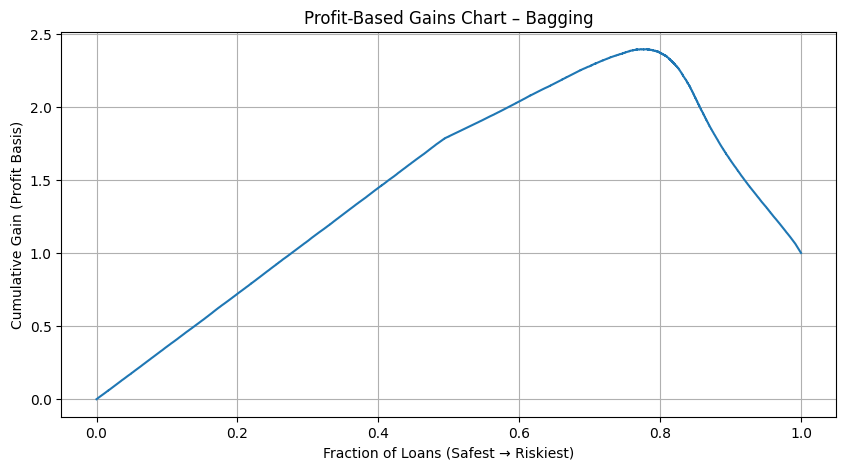

In [139]:
plt.figure(figsize=(10,5))
plt.plot(df_bag['fraction'], df_bag['gain'])
plt.title("Profit-Based Gains Chart – Bagging")
plt.xlabel("Fraction of Loans (Safest → Riskiest)")
plt.ylabel("Cumulative Gain (Profit Basis)")
plt.grid(True)
plt.show()


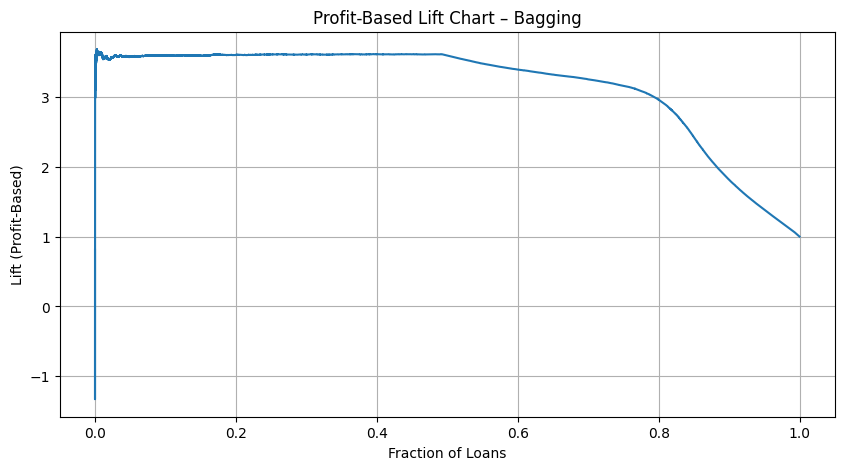

In [140]:
plt.figure(figsize=(10,5))
plt.plot(df_bag['fraction'], df_bag['lift'])
plt.title("Profit-Based Lift Chart – Bagging")
plt.xlabel("Fraction of Loans")
plt.ylabel("Lift (Profit-Based)")
plt.grid(True)
plt.show()


# Part 3 (A)
According to the gains curve, cumulative net profit peaked following approval of roughly: 78.16% of the loans for validation (as best_fraction_bag = 0.781574 indicates). Accordingly, only the safest ~78% of loan applications should be approved by the bank, according to the bagging model. Approving the remaining riskier loans after this point lowers the overall anticipated profit.

# Part 3 (b)

The default probability that matched the highest profit point was:
Standard Probability Cutoff = 0.22
The probability of success (PIF = 1 − default probability) cutoff is therefore:
Success Probability Cutoff , 1 − 0.22=0.78
Hence:
The Ultimate Bank Decision Rule
A loan should only be granted if the predicted probability of success (PIF) is at least 0.78.
If not, reject the loan due to its anticipated negative profit contribution.
This cutoff is based on maximizing financial return, which is the right strategy given the assignment's cost structure, rather than conventional accuracy metrics.
